In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
import time
import pickle

In [29]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# 環境設定

In [30]:
DATA_PATH = "./data"
RESULT_PATH = "./results"

# 関数定義

In [31]:
def cosine_similarity(y_true, y_pred):
    if isinstance(y_true, pd.Series):
        y_true = y_true.values.reshape(-1)
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values.reshape(-1)
    score = np.dot(y_true, y_pred) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))
    return score

# 分析

## データ読み込み

In [32]:
train_data = pd.read_parquet(Path(DATA_PATH, "train.parquet"))
test_data = pd.read_parquet(Path(DATA_PATH, "test.parquet"))

## モデルの学習

In [33]:
# サンプリング（時間短縮のため）
# sample_train_data = train_data.sample(frac=0.2)

In [34]:
# データ分割
# TODO: 時系列データであることを考慮すべき？
feature_cols = train_data.drop(columns=["id", "target"]).columns
target_col = "target"
X_train, X_valid, y_train, y_valid = train_test_split(
    train_data[feature_cols], 
    train_data[target_col], 
    test_size=0.3,
    shuffle=False # Trueにしないと学習がすぐ終わる
)
print(f'X_trainのshape:{X_train.shape}')
print(f'y_trainのshape:{y_train.shape}')
print(f'X_validのshape:{X_valid.shape}')
print(f'y_validのshape:{y_valid.shape}')

X_trainのshape:(462000, 695)
y_trainのshape:(462000,)
X_validのshape:(198000, 695)
y_validのshape:(198000,)


In [35]:
# パラメータの準備
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric': 'rmse',
    'num_leaves':16,
    'learning_rate':0.1,
    'n_estimators':30000, # ここで計算時間の上限をある程度決められる
    'random_state':0
}

In [36]:
# インスタンスの作成
clf = lgb.LGBMRegressor(**params)

In [37]:
# モデルの学習
start_time = time.time()
clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train),(X_valid, y_valid)],
    early_stopping_rounds=10
)
print(f"学習にかかった時間：{time.time() - start_time}")

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[1]	training's rmse: 1.05893	valid_1's rmse: 0.844962
[2]	training's rmse: 1.05843	valid_1's rmse: 0.844979
[3]	training's rmse: 1.05799	valid_1's rmse: 0.844986
[4]	training's rmse: 1.05757	valid_1's rmse: 0.845029
[5]	training's rmse: 1.05721	valid_1's rmse: 0.845022
[6]	training's rmse: 1.05686	valid_1's rmse: 0.845045
[7]	training's rmse: 1.05651	valid_1's rmse: 0.845101
[8]	training's rmse: 1.05614	valid_1's rmse: 0.84513
[9]	training's rmse: 1.05583	valid_1's rmse: 0.845205
[10]	training's rmse: 1.05556	valid_1's rmse: 0.845247
[11]	training's rmse: 1.05529	valid_1's rmse: 0.845237
学習にかかった時間：23.126369953155518


In [38]:
# 精度
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
print(f"trainの精度：{cosine_similarity(y_train, y_train_pred)}")
print(f"validの精度：{cosine_similarity(y_valid, y_valid_pred)}")

trainの精度：0.07272275498223026
validの精度：0.007635229796593228


## テストデータの予測

In [39]:
# 予測
id_test = test_data["id"].values.reshape(-1)
X_test = test_data.drop(columns=["id"]).copy()
y_test_pred = clf.predict(X_test)

In [40]:
# 保存
result = pd.DataFrame(data=y_test_pred, index=id_test, columns=["target"]).reset_index().rename(columns={"index": "id"})
result.to_csv(Path(RESULT_PATH, "20230825_result.csv"), index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

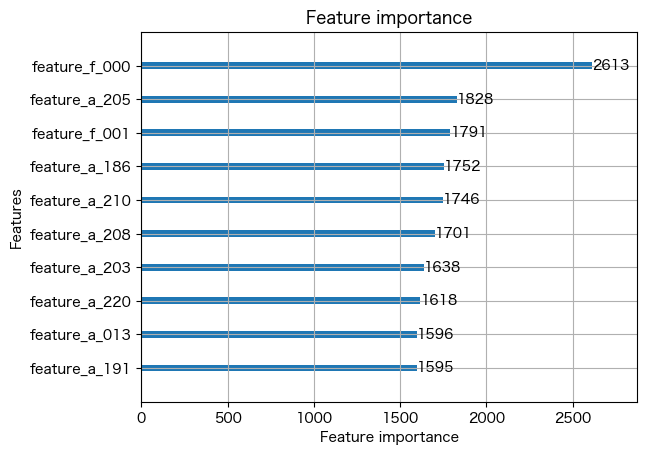

In [27]:
lgb.plot_importance(clf, max_num_features=10)

In [21]:
pickle.dump(clf, open("./models/20230822_lightgbm_ver3.sav", 'wb'))

## モデルの考察

In [37]:
explainer = shap.TreeExplainer(clf, data=X_train)

In [ ]:
# 時間かかりすぎる
train_shap_values = explainer.shap_values(X_train)

  0%|                   | 466/462000 [01:14<1221:30]       

In [ ]:
shap.summary_plot(shap_values=train_shap_values,
                  features=X_train,
                  feature_names=X_train.columns)